## DESI Iron
Determine how many galaxies were observed in DESI Iron that are good TF targets by finding the number of unique galaxies observed with observations at the center and at .4R.

In [1]:
## Module imports and constant definitions
from astropy.table import unique, Table
from astropy.coordinates import SkyCoord
from astropy.io import fits

import astropy.units as u

import numpy as np


#import matplotlib as mpl
#import matplotlib.pyplot as plt
import ligo.skymap.plot
from matplotlib import pyplot as plt

from tqdm.auto import tqdm

import os

import requests

from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

In [2]:
h=1
H0 = 100*h

c = 3e5

q0 = 0.2

V0 = 2.5 # 0-point of TFR

## Iron Data
We read in the Iron data to use throughout the notebook. Commented out below is the Fuji data, to use to check against when necessary.

In [3]:
tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_iron_healpix.fits')
#tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

tiron[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
2852147603439621,198.369130660983,36.5372037049171,10475,main,0.815976335547845,7.38513168100107e-05,4,0.128754377365112,iron/healpix/main/dark/104/10475/redrock-main-dark-10475.fits,EXT,649377,198.36913066098333,36.537203704917076
2399148812795907,198.371733180003,36.4994335406917,10475,main,1.11088784970434,7.48767797671894e-05,4,7.9473560154438,iron/healpix/main/bright/104/10475/redrock-main-bright-10475.fits,EXT,649377,198.37173318000336,36.499433540691676
2399382443917318,184.845242475328,49.8157304793777,10995,main,1.14739342108157,0.000146302276719084,4,2.56771463155746,iron/healpix/main/bright/109/10995/redrock-main-bright-10995.fits,EXT,1008911,184.84524247532795,49.81573047937771
2399634072797192,184.341289722203,70.8283725474297,11965,main,1.51703376230705,6.28979649962091e-05,4,4.76254060305655,iron/healpix/main/bright/119/11965/redrock-main-bright-11965.fits,EXT,241234,184.34128972220284,70.82837254742968
2852141710442505,123.256011148025,36.2652948002806,6448,main,0.00787379494184006,3.4714052819995e-05,0,22.1719104201402,iron/healpix/main/dark/64/6448/redrock-main-dark-6448.fits,EXT,31591,123.25601114802525,36.26529480028061


## SGA
We read in the SGA to use throughout the notebook.

In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

## Create a dictionary of SGA IDs to find row indices
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i
    
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## Separation between Galaxies and Observations
Find all targets on each galaxy, and then calculate distance between SGA center coordinates and observation coordinates. Store the lists of center and axis observations as `iron_centers` and `iron_axis`.

In [5]:
tiron['SKY_FIBER_DIST']=0.
tiron['SKY_FIBER_DIST_R26']=0.

## For each SGA galaxy that has 1+ observations, calculate distance for all of its targets
for sga_id in tqdm(np.unique(tiron['SGA_ID'])):
    
    ## Identify all galaxy targets on this galaxy
    obs_idx = tiron['SGA_ID'] == sga_id
    
    ## Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    ## Calculate distance between each observation and the center of the galaxy
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx],
                          dec=SGA['DEC'][sga_idx],
                          unit=u.degree)
    target_coords = SkyCoord(ra=tiron['RA'][obs_idx],
                             dec=tiron['DEC'][obs_idx],
                             unit=u.degree)
    sep2d = target_coords.separation(SGA_coords)
    
    ## Add the distance to the tiron table
    tiron['SKY_FIBER_DIST'][obs_idx] = sep2d
    
    ## Add the distance in R26 to the tiron table 
    tiron['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)

  0%|          | 0/75152 [00:00<?, ?it/s]

In [6]:
## Isolate the centers to be those measurements where the distance is <.1*R26
centers_boolean = tiron['SKY_FIBER_DIST_R26'] < 0.1

## Sort observations into center and axis observations 
iron_centers = tiron[centers_boolean]
iron_axis = tiron[~centers_boolean]

## Cleaning Iron Center Observations
Only keep observations with
- DELTACHI2 > 25
- ZWARN = 0

In [7]:
good_centers = iron_centers[(iron_centers['DELTACHI2'] > 25) & (iron_centers['ZWARN'] == 0)]

## Check for multiple good center observations 
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

If there is at least one good center observation, set the galaxy's redshift as the weighted average of all observation redshifts.

In [8]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in tqdm(np.unique(good_centers['SGA_ID'])):
    
    ## Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    ## Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be weighted average of all good center observation redshifts
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

  0%|          | 0/70100 [00:00<?, ?it/s]

Determine how many observations we have at 0.4𝑅26 that have a corresponding center observation for that galaxy.

In [9]:
## Include all observations where .38R < distance < .42R in our .4R values
r0p4 = iron_axis[(iron_axis['SKY_FIBER_DIST_R26'] > 0.38) & (iron_axis['SKY_FIBER_DIST_R26'] < 0.42)]

## Count how many of these are unique values
unique_centers = np.unique(good_centers['SGA_ID'])
unique_r0p4 = np.unique(r0p4['SGA_ID'])

centers_and_p4s = []
for i in unique_r0p4: 
    if i in unique_centers: 
        centers_and_p4s.append(i)

## Output the number of observations that are generally good for TF fitting
print(len(centers_and_p4s), "unique galaxies with center and 0.4R observations")

## Find the percentage of all Iron galaxies that are generally good for TF fitting
num_iron = len(np.unique(tiron['SGA_ID']))
percentage_TF = 100*((len(centers_and_p4s))/num_iron)
print(f"{percentage_TF:.1f}% of all Iron galaxies")

11819 unique galaxies with center and 0.4R observations
15.7% of all Iron galaxies


## Cluster Membership
Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

### Tully et al. (2015) Table 3

In [10]:
hdu = fits.open("../Tully15-Table3.fits")
table3 = Table(hdu[1].data)
table3.rename_column("<Vcmba>","VMod")
hdu.close()

table3_dict = {}
for i in range(len(table3)):
    table3_dict[table3['Nest'][i]] = i

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,VMod,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


Loop through the SGA table and collect just the rows with SGA_ID values that are included in centers_and_p4s in a new table.

In [11]:
SGA.add_index("SGA_ID")
TF_SGA_cp4 = SGA.loc[centers_and_p4s]

TF_SGA_cp4[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06
55,SGA-2020 55,PGC1203947,1203947,199.73061299999998,1.7263548999999998,S?,159.49,0.35156044,0.510505,0.04396308,24.6

## Determine Iron Cluster Membership
This cell loops through all Nest numbers given in Tully 2015 Table 3, determines the coordinates, and matches galaxies to their nearest cluster. It collects the center and axis observations for each cluster, and stores the Nest number in `full_clusters` along with a table of center and axis observations in `c_4r_in_cluster`. 

At present, this cell is returning some suspicious values.

In [12]:
full_cluster = []
v_cluster = []
c_4r_in_cluster = []

# Define SGA galaxy coordinates object
SGA_coords = SkyCoord(TF_SGA_cp4['RA'], TF_SGA_cp4['DEC'], unit='deg')

for nest_id in tqdm(table3["Nest"]):
    
    ## Set active row for each nest number and base values 
    i_cluster = table3_dict[nest_id]
    
    R2t = table3["R2t"][i_cluster]
    sigma = table3["sigP"][i_cluster]
    mu = table3['DM'][i_cluster]
    
    ## Find the coordinates for each cluster
    cluster_coords = SkyCoord(table3["SGLON"][i_cluster]*u.degree, 
                              table3["SGLAT"][i_cluster]*u.degree, 
                              frame='supergalactic')
    
    # print(cluster_coords, cluster_coords.transform_to('icrs'))
    
    ## Convert the distance modulus to velocity
    d = 10*10**(0.2*mu)
    v = 100*(d*1e-6)
    
    ## Match SGA coordinates from unique galaxies to nearest cluster
    sep = cluster_coords.separation(SGA_coords)

    ## Convert R2t to an angle 
    # R2t_angle = (R2t/(v/H0))*u.radian
    R2t_angle_1p5 = np.arctan(1.5*R2t/(v/H0))*u.radian
    R2t_angle_3 = np.arctan(3*R2t/(v/H0))*u.radian
    
    # SGA_in_cluster1 = (sep < 1.5*R2t_angle) & (TF_SGA_cp4["Z_DESI"]*c > v - 3*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 3*sigma)
    # SGA_in_cluster2 = (sep >= 1.5*R2t_angle) & (sep < 3*R2t_angle) & (TF_SGA_cp4["Z_DESI"]*c > v - 2*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 2*sigma)
    SGA_in_cluster1 = (sep < R2t_angle_1p5) & (TF_SGA_cp4["Z_DESI"]*c > v - 3*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 3*sigma)
    SGA_in_cluster2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (TF_SGA_cp4["Z_DESI"]*c > v - 2*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 2*sigma)
    
    SGA_in_cluster = SGA_in_cluster1 | SGA_in_cluster2
    
    ## Keep observations that are within nest cluster 
    SGA_ID_in_cluster = TF_SGA_cp4["SGA_ID"][SGA_in_cluster]
    
    ## Gather centers and axes in the cluster
    centers_in_cluster = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_cluster)]
    axis_in_cluster = iron_axis[np.in1d(iron_axis['SGA_ID'], SGA_ID_in_cluster)]
    
    if len(SGA_ID_in_cluster) > 20:
        print("CLUSTER ID:", nest_id, "--", len(SGA_ID_in_cluster), "GALAXIES"),
        full_cluster.append(nest_id)
        v_cluster.append(v)
        c_4r_in_cluster.append(SGA_ID_in_cluster)

  0%|          | 0/25474 [00:00<?, ?it/s]

CLUSTER ID: 100002 -- 83 GALAXIES
CLUSTER ID: 100007 -- 28 GALAXIES
CLUSTER ID: 100042 -- 36 GALAXIES
CLUSTER ID: 100046 -- 24 GALAXIES
CLUSTER ID: 100058 -- 31 GALAXIES
CLUSTER ID: 100067 -- 60 GALAXIES
CLUSTER ID: 100073 -- 25 GALAXIES
CLUSTER ID: 100077 -- 26 GALAXIES
CLUSTER ID: 100081 -- 23 GALAXIES
CLUSTER ID: 100094 -- 24 GALAXIES
CLUSTER ID: 100168 -- 23 GALAXIES
CLUSTER ID: 100221 -- 25 GALAXIES
CLUSTER ID: 100282 -- 38 GALAXIES
CLUSTER ID: 100368 -- 22 GALAXIES
CLUSTER ID: 100369 -- 24 GALAXIES
CLUSTER ID: 100503 -- 21 GALAXIES
CLUSTER ID: 101400 -- 45 GALAXIES
CLUSTER ID: 101434 -- 30 GALAXIES
CLUSTER ID: 101788 -- 36 GALAXIES
CLUSTER ID: 101823 -- 28 GALAXIES
CLUSTER ID: 102885 -- 25 GALAXIES
CLUSTER ID: 103172 -- 25 GALAXIES
CLUSTER ID: 103175 -- 28 GALAXIES
CLUSTER ID: 103182 -- 43 GALAXIES
CLUSTER ID: 103203 -- 30 GALAXIES
CLUSTER ID: 103206 -- 28 GALAXIES
CLUSTER ID: 103229 -- 31 GALAXIES
CLUSTER ID: 103332 -- 24 GALAXIES
CLUSTER ID: 160002 -- 26 GALAXIES
CLUSTER ID: 20

In [13]:
print(len(np.unique(np.concatenate(c_4r_in_cluster))), len(np.concatenate(c_4r_in_cluster)))

844 959


In [14]:
cluster_coords = SkyCoord(table3['SGLON']*u.degree, 
                          table3['SGLAT']*u.degree, 
                          frame='supergalactic')

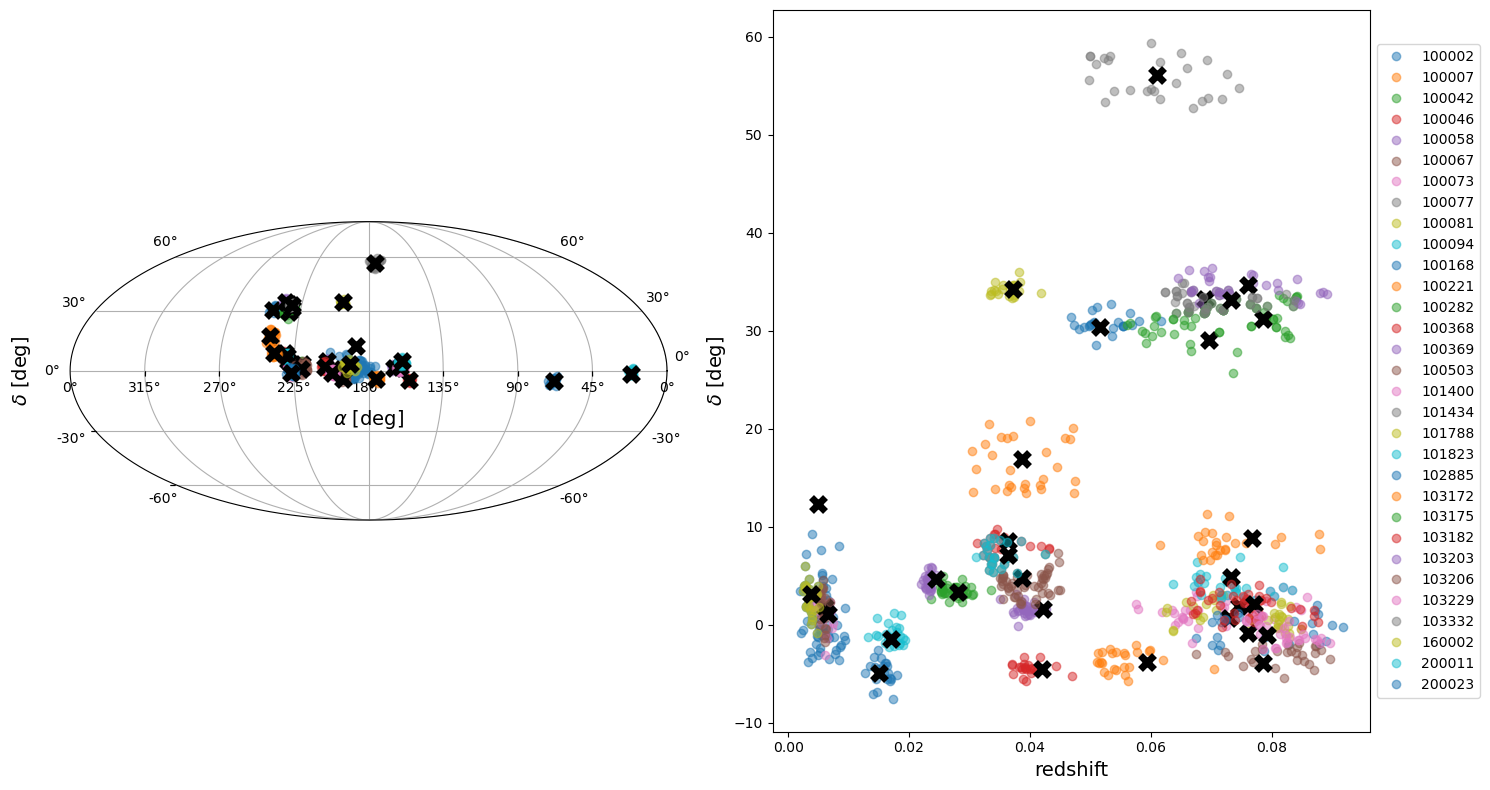

In [15]:
fig = plt.figure(figsize=(15,8), tight_layout=True)

# colors = ['tab:blue', 'tab:orange', 'tab:green']

ax_sky = plt.subplot(121, projection='astro degrees mollweide')#, center="180d 0d", radius='90 deg')
ax_sky.grid()
for i in range(len(full_cluster)):
    
    table3_i = table3_dict[full_cluster[i]]
    
    ax_sky.plot(TF_SGA_cp4.loc[c_4r_in_cluster[i]]['RA'], 
                TF_SGA_cp4.loc[c_4r_in_cluster[i]]['DEC'], 
                'o', 
                transform=ax_sky.get_transform('world'),
                alpha=0.5, label=str(full_cluster[i]))
    ax_sky.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
                cluster_coords[table3_i].transform_to('icrs').dec.deg, 
                'kx', 
                transform=ax_sky.get_transform('world'),
                ms=10, mew=5)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)

ax = plt.subplot(122)
for i in range(len(full_cluster)):
    
    table3_i = table3_dict[full_cluster[i]]
    
    ax.plot(TF_SGA_cp4.loc[c_4r_in_cluster[i]]['Z_DESI'], 
             TF_SGA_cp4.loc[c_4r_in_cluster[i]]['DEC'], 
             'o', alpha=0.5, label=str(full_cluster[i]))
    
    ax.plot(v_cluster[i]/c, 
             cluster_coords[table3_i].transform_to('icrs').dec.deg, 
             'kx', ms=10, mew=5)

# plt.xlim((0.0125, 0.035))
ax.set_xlabel('redshift', fontsize=14)
ax.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
3.6601122509446853 deg


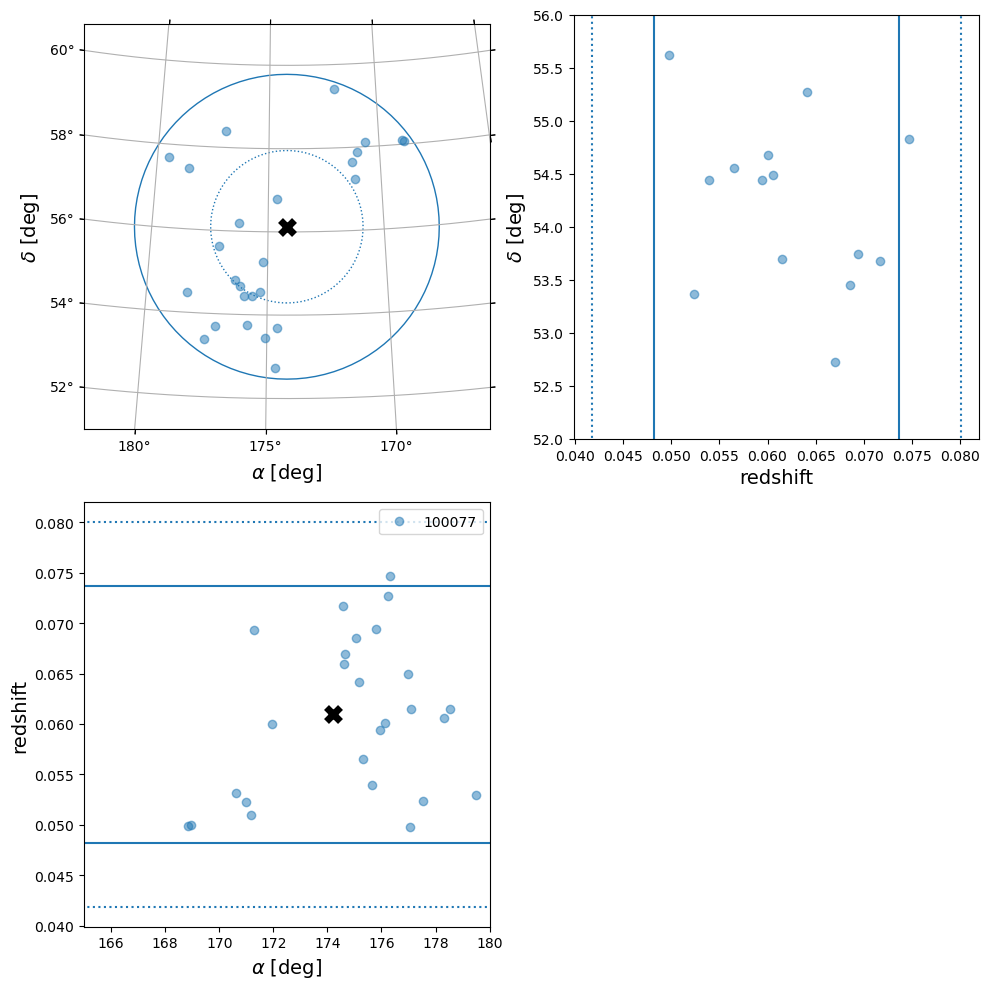

In [16]:
cluster = 100077

table3_i = table3_dict[cluster]
i = np.array(full_cluster) == cluster

cluster_center = cluster_coords[table3_i].transform_to('icrs')
print(cluster_center)

cluster_v = np.array(v_cluster)[i][0]

cluster_sigma = table3['sigP'][table3_i]
print(cluster_v, '+/-', cluster_sigma, 'km/s')

cluster_R2t_1p5 = np.arctan(1.5*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_3 = np.arctan(3*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_4 = np.arctan(4*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
print(cluster_R2t_3.to('degree'))



plt.figure(figsize=(10,10), tight_layout=True)

ax_sky = plt.subplot(221, projection='astro degrees zoom', center=cluster_center, radius=cluster_R2t_4)
ax_sky.grid()
    
ax_sky.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
            TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
            'o', 
            transform=ax_sky.get_transform('world'), 
            alpha=0.5, label=str(cluster))
ax_sky.plot(cluster_center.ra.deg, 
            cluster_center.dec.deg, 
            'kx', 
            transform=ax_sky.get_transform('world'), 
            ms=10, mew=5)

# 1.5 R2t
inner_limit = SphericalCircle(cluster_center, cluster_R2t_1p5, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
ax_sky.add_patch(inner_limit)

# 3 R2t
outer_limit = SphericalCircle(cluster_center, cluster_R2t_3, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
ax_sky.add_patch(outer_limit)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(222)
    
plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         'o', alpha=0.5, label=str(cluster))
    
plt.plot(cluster_v/c, 
         cluster_coords[table3_i].transform_to('icrs').dec.deg, 
         'kx', ms=10, mew=5)

# velocity limits
plt.vlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
            cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           -30, 90, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

#plt.xlim(xmin=0)
plt.ylim((52, 56))

plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(223)

plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         'o', alpha=0.5, label=str(cluster))

plt.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
         cluster_v/c, 
         'kx', ms=10, mew=5)

# velocity limits
plt.hlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
                     cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           0, 360, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

plt.xlim((165, 180))
# plt.ylim(ymin=0)

plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel('redshift', fontsize=14)

plt.legend();

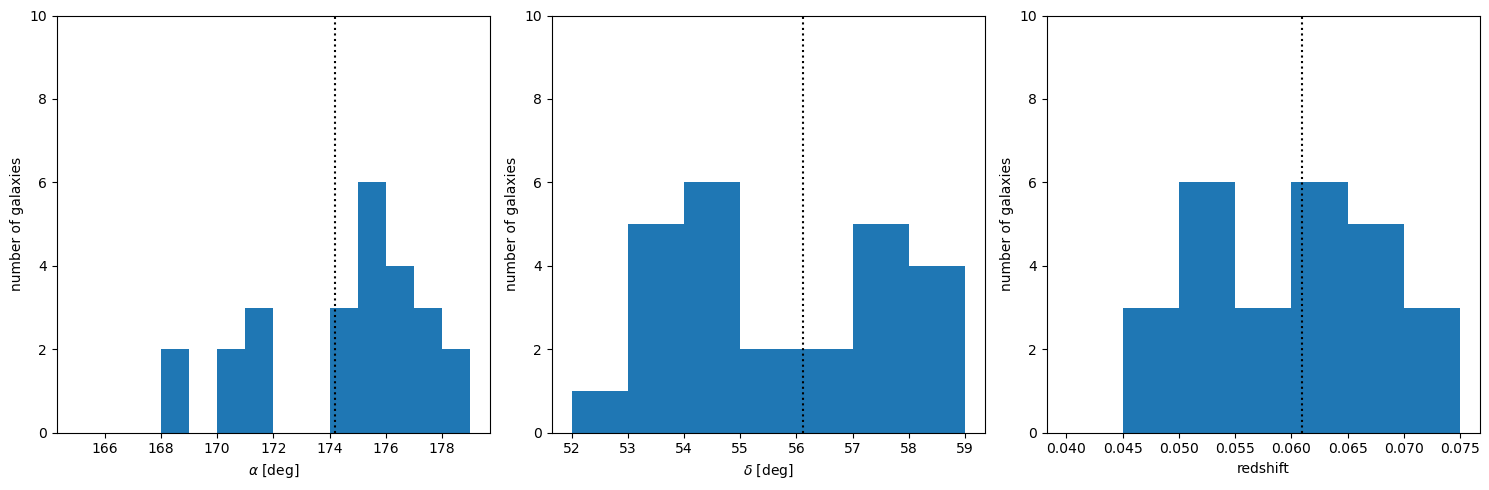

In [17]:
plt.figure(figsize=(15,5), tight_layout=True)

ymax = 10

plt.subplot(131)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         bins=np.arange(165, 180, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').ra.deg, 0, 50, colors='k', linestyles='dotted')
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(132)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         bins=np.arange(52, 60, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').dec.deg, 0, 100, colors='k', linestyles='dotted')
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(133)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         bins=np.arange(0.04, 0.08, 0.005))
plt.vlines(cluster_v/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax);

## Find $\Delta$z of Galaxy Clusters

In [18]:
## set up list of clusters to be examined for delta-z
cluster_idx = [100002, 100007, 100042, 100046, 100058, 100067, 100073, 100077]

## initialize array of delta-v values of each cluster
cluster_dv_over_sigP = []

## run through cluster_idx for examination of delta-z
for i in cluster_idx:
    cluster = i
    print('cluster index:', i)
    
    table3_i = table3_dict[cluster]
    i = np.array(full_cluster) == cluster

    cluster_v = np.array(v_cluster)[i][0]

    cluster_sigma = table3['sigP'][table3_i]
    print('The velocity of the center of cluster is', cluster_v, '+/-', cluster_sigma, 'km/s')

    ## create temporary data storage space to assign and sort z-values for galaxies
    temp_array = []

    ## assign z-values to the data storage space and convert to numpy array
    temp_array = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'])
    temp_array = temp_array.tolist()

    ## sort the z-values and find the median
    temp_array.sort()

    num_galaxy = len(temp_array)
    if (num_galaxy%2 == 0):
        z_median = (temp_array[num_galaxy//2] + temp_array[num_galaxy//2 - 1])/2
    else:
        z_median = temp_array[num_galaxy//2]
    
    delta_v = cluster_v - c*z_median
    dv_over_sigP = delta_v / cluster_sigma

    print('The median of the observed v-values of galaxies in cluster', cluster, 'is', c*z_median, 'and the value of delta-v is', delta_v, 'km/s')
    print('The ratio between delta-v and cluster_sigma for cluster', cluster, 'is', dv_over_sigP)
    print('------------------------------------------------------------------------------------------------------------')
    
    ## store dv_over_sigP in cluster_dv_over_sigP
    cluster_dv_over_sigP.append(dv_over_sigP)

cluster index: 100002
The velocity of the center of cluster is 1492.7944095789974 +/- 707 km/s
The median of the observed v-values of galaxies in cluster 100002 is 1461.882727287204 and the value of delta-v is 30.91168229179334 km/s
The ratio between delta-v and cluster_sigma for cluster 100002 is 0.04372232290211222
------------------------------------------------------------------------------------------------------------
cluster index: 100007
The velocity of the center of cluster is 11587.773561551261 +/- 1385 km/s
The median of the observed v-values of galaxies in cluster 100007 is 11414.244873115094 and the value of delta-v is 173.5286884361667 km/s
The ratio between delta-v and cluster_sigma for cluster 100007 is 0.12529147179506622
------------------------------------------------------------------------------------------------------------
cluster index: 100042
The velocity of the center of cluster is 8433.347577642775 +/- 545 km/s
The median of the observed v-values of galaxies 

## Find $\Delta$$\theta$ of Galaxy Clusters

Method 1: find median of coordinates, then calculate angular separation from cluster center

In [19]:
## set up list of clusters to be examined for delta-theta
cluster_idx = [100002, 100007, 100042, 100046, 100058, 100067, 100073, 100077]

## initialize array for storing delta-theta value of each cluster and delta-theta/R2t
cluster_dtheta = []
cluster_dtheta_over_R2t = []

## run through cluster_idx for examination of delta-theta
for i in cluster_idx:
    cluster = i
    print('cluster index:', i)
    
    table3_i = table3_dict[cluster]
    i = np.array(full_cluster) == cluster

    cluster_center = cluster_coords[table3_i].transform_to('icrs')
    print(cluster_center)

    # assign RA and DEC data to temp_array1 and temp_array2
    # translate temp_array1 and temp_array2 into lists
    temp_array1 = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'])
    temp_array1 = temp_array1.tolist()

    temp_array2 = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'])
    temp_array2 = temp_array2.tolist()

    # sort the lists and find the medians
    temp_array1.sort()

    num_galaxy = len(temp_array1)
    if (num_galaxy%2 == 0):
        RA_median = (temp_array1[num_galaxy//2] + temp_array1[num_galaxy//2 - 1])/2
    else:
        RA_median = temp_array1[num_galaxy//2]
    
    temp_array2.sort()

    num_galaxy = len(temp_array2)
    if (num_galaxy%2 == 0):
        DEC_median = (temp_array2[num_galaxy//2] + temp_array2[num_galaxy//2 - 1])/2
    else:
        DEC_median = temp_array2[num_galaxy//2]

    # compare the median to the cluster center
    print('The median of the measured coordinates are', RA_median, DEC_median)

    print('The center of the cluster is', cluster_center.ra, cluster_center.dec)

    # translate RA_median and DEC_median into units used in SkyCoord
    RA_d = int(RA_median)
    RA_m = int((RA_median - RA_d) * 60)
    RA_s = ((RA_median - RA_d) * 60 - RA_m) * 60

    RA_median_dms = str(RA_d) + 'd' + str(RA_m) + 'm' + str(RA_s) + 's'
    print(RA_median_dms)

    DEC_d = int(DEC_median)
    DEC_m = int((DEC_median - DEC_d) * 60)
    DEC_s = ((DEC_median - DEC_d) * 60 - DEC_m) * 60

    DEC_median_dms = str(DEC_d) + 'd' + str(DEC_m) + 'm' + str(DEC_s) + 's'
    print(DEC_median_dms)

    Median_Coord = SkyCoord(RA_median_dms, DEC_median_dms, frame = 'icrs')

    sep = Median_Coord.separation(cluster_center)
    print('The angle of separation between the median coordinate and the cluster center for cluster', cluster, 'is', sep.degree)
    
    ##store sep.degree in cluster_dtheta
    cluster_dtheta.append(sep.degree)
    cluster_dtheta_over_R2t.append(sep.degree/R2t)
    
    print('The ratio between the angle of separation and R2t for the cluster is', sep.degree/R2t)
    print('------------------------------------------------------------------------------------------------------------')

cluster index: 100002
<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
The median of the measured coordinates are 189.51384366669885 1.4646429031292836
The center of the cluster is 187d45m49.71818364s 12d16m57.51815056s
189d30m49.837200115848646s
1d27m52.714451265420834s
The angle of separation between the median coordinate and the cluster center for cluster 100002 is 10.956209477550825
The ratio between the angle of separation and R2t for the cluster is 26.59274145036608
------------------------------------------------------------------------------------------------------------
cluster index: 100007
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
The median of the measured coordinates are 240.6307798704871 15.825942937297242
The center of the cluster is 241d03m29.10668604s 16d57m15.90262091s
240d37m50.8075337535206s
15d49m33.39457427007119s
The angle of separation between the median coordinate and the cluster center for cluster 100007 is 1.200624

Plot scatterplot using data from Method 1

<function matplotlib.pyplot.show(close=None, block=None)>

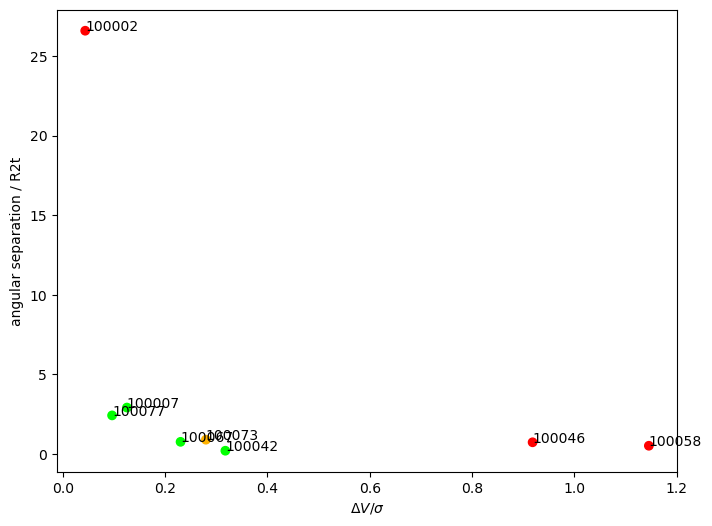

In [20]:
## mark which clusters are suitable for analysis; Y (green) for yes; N (red) for no; U (orange) for unsure
Y = (0, 1, 0)
N = (1, 0, 0)
U = (1, 0.7, 0)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

cluster_suit = [N, Y, Y, N, N, Y, U, Y]

plt.scatter(x = cluster_dv_over_sigP, 
            y = cluster_dtheta_over_R2t,
            c = cluster_suit)
plt.xlabel('$\Delta V / \sigma$')
plt.ylabel('angular separation / R2t')

for i, txt in enumerate(cluster_idx):
    ax.text(cluster_dv_over_sigP[i], cluster_dtheta_over_R2t[i], txt)

plt.show

Method 2: find angular separation between each galaxy and cluster center, then find median of angular separation

In [21]:
## set up list of clusters to be examined for delta-theta
cluster_idx = [100002, 100007, 100042, 100046, 100058, 100067, 100073, 100077]

## intialize array for storing median angular separation for each cluster
sep_median_array = []

## run through cluster_idx for examination of delta-theta
for i in cluster_idx:
    cluster = i
    print('cluster index:', i)

    table3_i = table3_dict[cluster]
    i = np.array(full_cluster) == cluster

    cluster_center = cluster_coords[table3_i].transform_to('icrs')
    print(cluster_center)

    ## assign RA and DEC data to temp_array1 and temp_array2
    ## translate temp_array1 and temp_array2 into lists
    temp_array1 = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'])
    temp_array1 = temp_array1.tolist()

    temp_array2 = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'])
    temp_array2 = temp_array2.tolist()

    ## for each combination of RA and DEC, form a SkyCoord object, and find its separation from cluster_center
    ## store the separations in sep_array
    sep_array = []

    for i in range(len(temp_array1)):
        ## translate decimals into degrees
        galaxy_RA = temp_array1[i]
        galaxy_DEC = temp_array2[i]
    
        RA_d = int(galaxy_RA // 1)
        RA_m = int((galaxy_RA - RA_d) * 60 // 1)
        RA_s = ((galaxy_RA - RA_d) * 60 // 1 - RA_m) * 60

        RA_dms = str(RA_d) + 'd' + str(RA_m) + 'm' + str(RA_s) + 's'

        DEC_d = int(galaxy_DEC // 1)
        DEC_m = int((galaxy_DEC - DEC_d) * 60 // 1)
        DEC_s = ((galaxy_DEC - DEC_d) * 60 // 1 - DEC_m) * 60

        DEC_dms = str(DEC_d) + 'd' + str(DEC_m) + 'm' + str(DEC_s) + 's'
    
        galaxy_coord = SkyCoord(RA_dms, DEC_dms, frame = 'icrs')
    
        sep = galaxy_coord.separation(cluster_center)
    
        sep_array.append(sep)
        sep_array.sort()
    
        num_galaxy = len(sep_array)
        if (num_galaxy%2 == 0):
            sep_median = (sep_array[num_galaxy//2] + sep_array[num_galaxy//2 - 1])/2
        else:
            sep_median = sep_array[num_galaxy//2]
    
    sep_median_array.append(sep_median.deg)
    
    print('The median angular separation between the cluster center and each galaxy is', sep_median, '.')
    print('---------------------------------------------------------------------------------------------')

cluster index: 100002
<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
The median angular separation between the cluster center and each galaxy is 12d16m30.56555526s .
---------------------------------------------------------------------------------------------
cluster index: 100007
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
The median angular separation between the cluster center and each galaxy is 2d59m01.45104153s .
---------------------------------------------------------------------------------------------
cluster index: 100042
<SkyCoord (ICRS): (ra, dec) in deg
    (220.13676059, 3.3706831)>
The median angular separation between the cluster center and each galaxy is 1d21m05.23676993s .
---------------------------------------------------------------------------------------------
cluster index: 100046
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
The median angular separation between the cluster center and each galaxy

Plot scatterplot using data from Method 2

<function matplotlib.pyplot.show(close=None, block=None)>

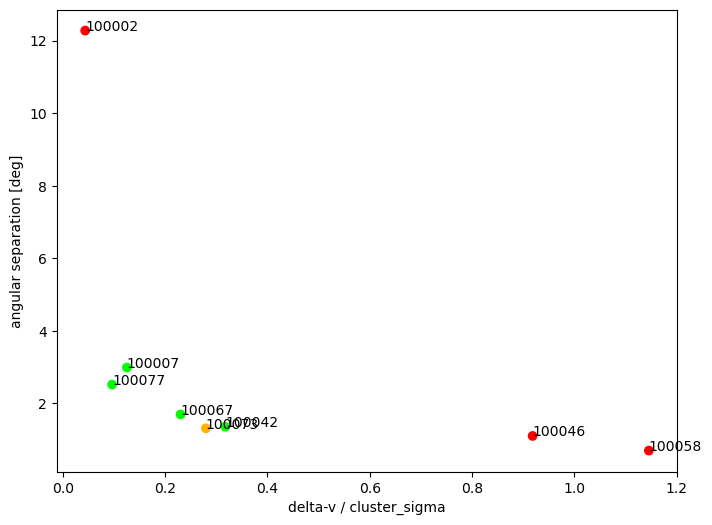

In [22]:
## mark which clusters are suitable for analysis; Y (green) for yes; N (red) for no; U (orange) for unsure
Y = (0, 1, 0)
N = (1, 0, 0)
U = (1, 0.7, 0)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

cluster_suit = [N, Y, Y, N, N, Y, U, Y]

plt.scatter(x = cluster_dv_over_sigP, 
            y = sep_median_array,
            c = cluster_suit)
plt.xlabel('delta-v / cluster_sigma')
plt.ylabel('angular separation [deg]')

for i, txt in enumerate(cluster_idx):
    ax.text(cluster_dv_over_sigP[i], sep_median_array[i], txt)

plt.show

From the results of these scatter plots, the analysis for angular separation will be done via Method 1. Clusters with a delta-v/cluster_sigma < 0.4 and angular separation < 2 degrees will be selected for the fitting of the Tully-Fisher relationship.

## Expand the analysis to all clusters in full_cluster

Expand the for_loop used for determining delta-v/cluster_sigma and angular separation to all clusters included in full_cluster, and if a cluster has dv/$sigma$ < 0.4 and angular separation < 2 degrees, store the nest_id of the cluster.

Find delta-v/cluster_sigma for all clusters.

In [23]:
## note: currently considering deleting all the print() lines and just leaving the calculation portion to minimize on-screen data output.

## set up list of clusters to be examined for delta-z
cluster_idx = full_cluster

## initialize array of delta-v values of each cluster
cluster_dv_over_sigP = []

## run through cluster_idx for examination of delta-z
for i in cluster_idx:
    cluster = i
    
    table3_i = table3_dict[cluster]
    i = np.array(full_cluster) == cluster

    cluster_v = np.array(v_cluster)[i][0]

    cluster_sigma = table3['sigP'][table3_i]

    ## assign z-values to the data storage space and convert to numpy array
    temp_array = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'])
    z_median = np.median(temp_array)
    
    delta_v = np.absolute(cluster_v - c*z_median)
    dv_over_sigP = delta_v / cluster_sigma
    
    ## store dv_over_sigP in cluster_dv_over_sigP
    cluster_dv_over_sigP.append(dv_over_sigP)

Find angular separation for all clusters.

In [24]:
## set up list of clusters to be examined for delta-theta
cluster_idx = full_cluster

## initialize array for storing delta-theta / R2t value of each cluster
cluster_dtheta_over_R2t = []

## run through cluster_idx for examination of delta-theta
for i in cluster_idx:
    cluster = i
    
    table3_i = table3_dict[cluster]
    i = np.array(full_cluster) == cluster

    cluster_center = cluster_coords[table3_i].transform_to('icrs')

    ## assign RA and DEC data to temp_array1 and temp_array2
    ## translate temp_array1 and temp_array2 into lists
    temp_array1 = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'])
    RA_median = np.median(temp_array1)

    temp_array2 = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'])
    DEC_median = np.median(temp_array2)

    ## translate RA_median and DEC_median into units used in SkyCoord
    RA_d = int(RA_median // 1)
    RA_m = int((RA_median - RA_d) * 60 // 1)
    RA_s = ((RA_median - RA_d) * 60 - RA_m) * 60

    RA_median_dms = str(RA_d) + 'd' + str(RA_m) + 'm' + str(RA_s) + 's'

    DEC_d = int(DEC_median // 1)
    DEC_m = int(np.absolute((DEC_median - DEC_d) * 60 // 1))
    DEC_s = np.absolute(((DEC_median - DEC_d) * 60 - DEC_m) * 60)

    DEC_median_dms = str(DEC_d) + 'd' + str(DEC_m) + 'm' + str(DEC_s) + 's'

    Median_Coord = SkyCoord(RA_median_dms, DEC_median_dms, frame = 'icrs')

    sep = Median_Coord.separation(cluster_center)
    
    ## store sep.degree in cluster_dtheta
    cluster_dtheta_over_R2t.append(sep.degree/R2t)

In [25]:
suited_clusters = []
cluster_suit = []

for i in range(len(cluster_idx)):
    if(cluster_dv_over_sigP[i] < 0.4 and cluster_dtheta_over_R2t[i] < 5):
        suited_clusters.append(cluster_idx[i])
        cluster_suit.append(Y)
    else:
        cluster_suit.append(N)

print(suited_clusters)

[100007, 100042, 100067, 100073, 100077, 100081, 100168, 100282, 101823, 103175, 103182, 160002, 200011]


<function matplotlib.pyplot.show(close=None, block=None)>

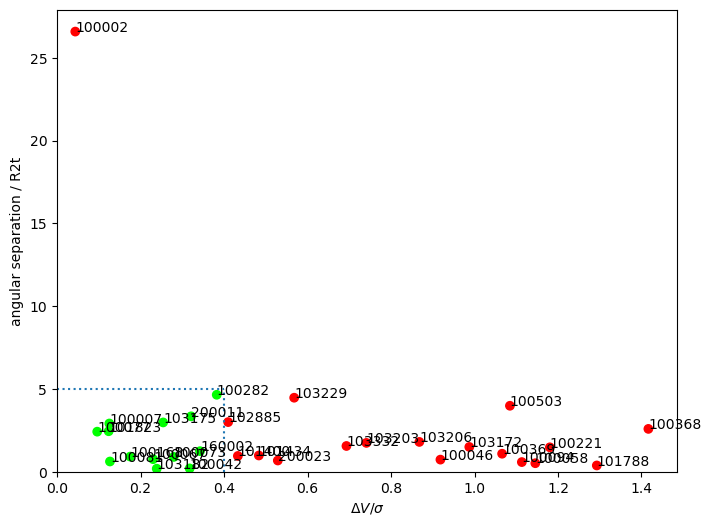

In [26]:
## mark which clusters are suitable for analysis; Y (green) for yes; N (red) for no; U (orange) for unsure
Y = (0, 1, 0)
N = (1, 0, 0)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

plt.scatter(x = cluster_dv_over_sigP, 
            y = cluster_dtheta_over_R2t,
            c = cluster_suit)
plt.xlabel('$\Delta V / \sigma$')
plt.ylabel('angular separation / R2t')

for i, txt in enumerate(cluster_idx):
    ax.text(cluster_dv_over_sigP[i], cluster_dtheta_over_R2t[i], txt)
    
plt.xlim(0,)
plt.ylim(0,)

plt.vlines(0.4,
          ymin = 0,
          ymax = 5,
          linestyles = 'dotted')
plt.hlines(5,
          xmin = 0,
          xmax = 0.4,
          linestyles = 'dotted')
    
plt.show

Inspecting the clusters between 0.4 and 0.6 in terms of $\Delta V / \sigma$

In [27]:
cluster_inspection = []

for i in range(len(cluster_idx)):
    if(cluster_dv_over_sigP[i] < 0.6 and cluster_dv_over_sigP[i] > 0.4):
        cluster_inspection.append(cluster_idx[i])

print(cluster_inspection)

[101400, 101434, 102885, 103229, 200023]


<SkyCoord (ICRS): (ra, dec) in deg
    (160.81499432, 1.91346557)>
22387.211385683422 +/- 1711 km/s
2.6730481738370986 deg


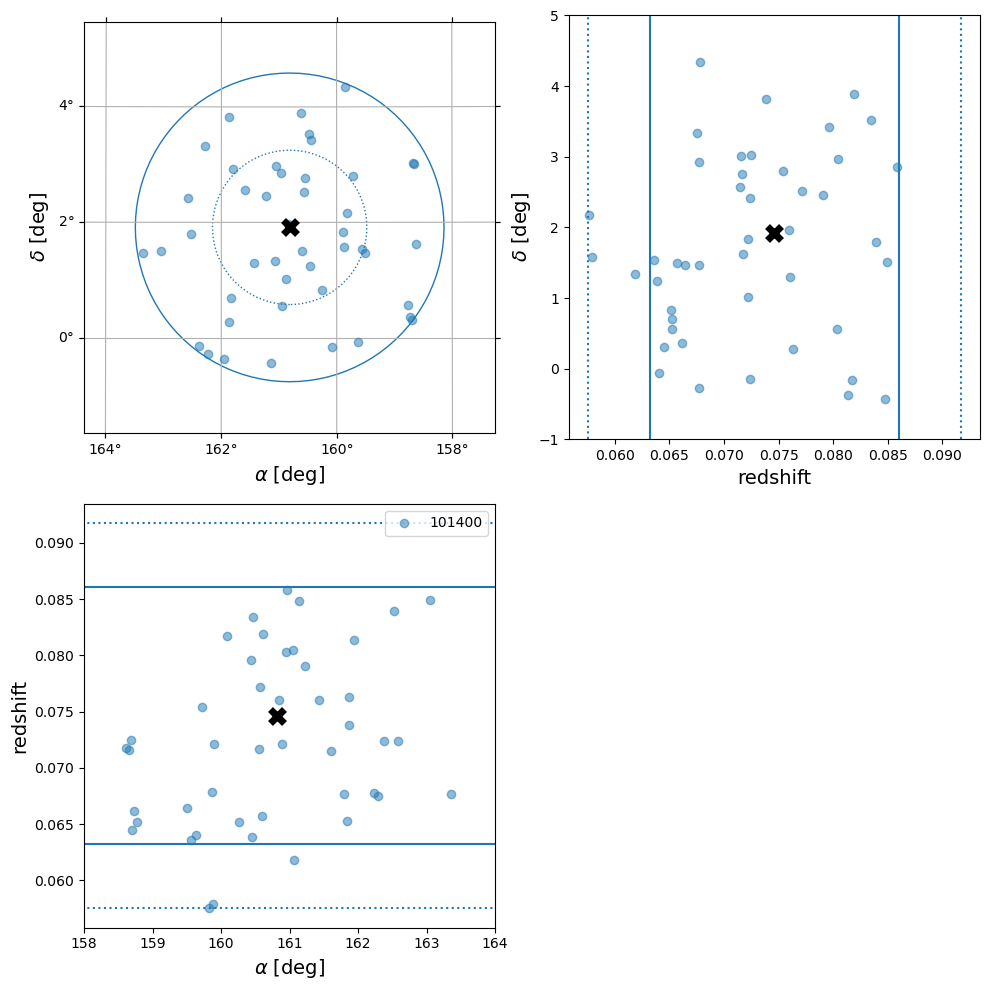

In [28]:
cluster = 101400

table3_i = table3_dict[cluster]
i = np.array(full_cluster) == cluster

cluster_center = cluster_coords[table3_i].transform_to('icrs')
print(cluster_center)

cluster_v = np.array(v_cluster)[i][0]

cluster_sigma = table3['sigP'][table3_i]
print(cluster_v, '+/-', cluster_sigma, 'km/s')

cluster_R2t_1p5 = np.arctan(1.5*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_3 = np.arctan(3*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_4 = np.arctan(4*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
print(cluster_R2t_3.to('degree'))



plt.figure(figsize=(10,10), tight_layout=True)

ax_sky = plt.subplot(221, projection='astro degrees zoom', center=cluster_center, radius=cluster_R2t_4)
ax_sky.grid()
    
ax_sky.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
            TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
            'o', 
            transform=ax_sky.get_transform('world'), 
            alpha=0.5, label=str(cluster))
ax_sky.plot(cluster_center.ra.deg, 
            cluster_center.dec.deg, 
            'kx', 
            transform=ax_sky.get_transform('world'), 
            ms=10, mew=5)

# 1.5 R2t
inner_limit = SphericalCircle(cluster_center, cluster_R2t_1p5, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
ax_sky.add_patch(inner_limit)

# 3 R2t
outer_limit = SphericalCircle(cluster_center, cluster_R2t_3, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
ax_sky.add_patch(outer_limit)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(222)
    
plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         'o', alpha=0.5, label=str(cluster))
    
plt.plot(cluster_v/c, 
         cluster_coords[table3_i].transform_to('icrs').dec.deg, 
         'kx', ms=10, mew=5)

# velocity limits
plt.vlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
            cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           -30, 90, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

#plt.xlim(xmin=0)
plt.ylim((-1, 5))

plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(223)

plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         'o', alpha=0.5, label=str(cluster))

plt.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
         cluster_v/c, 
         'kx', ms=10, mew=5)

# velocity limits
plt.hlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
                     cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           0, 360, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

plt.xlim((158, 164))
# plt.ylim(ymin=0)

plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel('redshift', fontsize=14)

plt.legend();

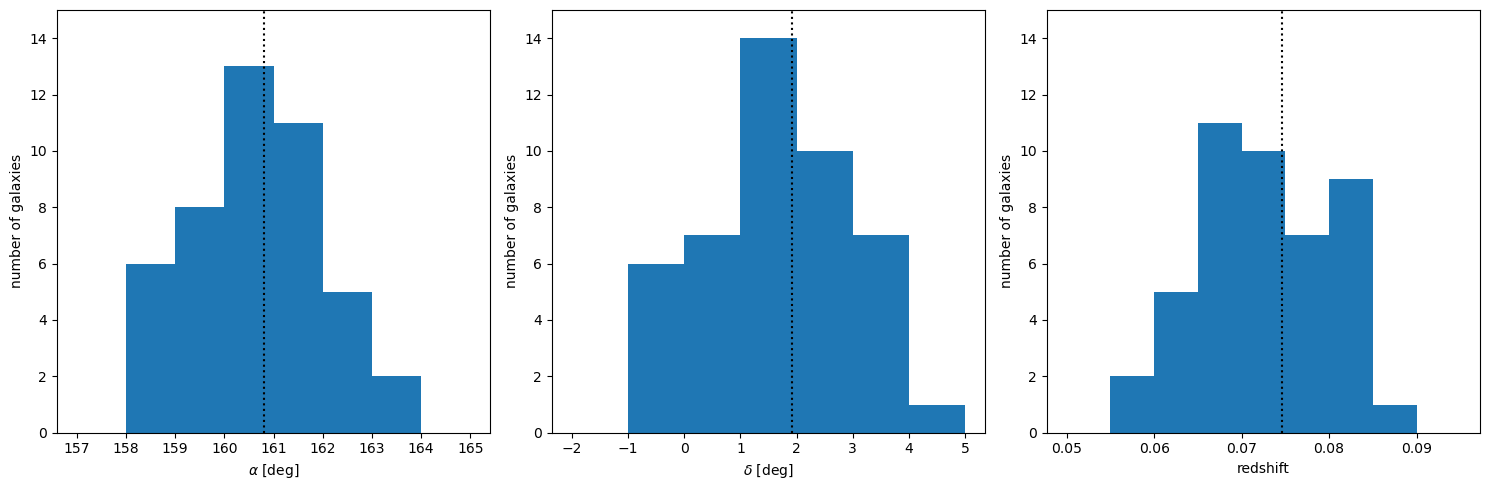

In [29]:
plt.figure(figsize=(15,5), tight_layout=True)

ymax = 15

plt.subplot(131)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         bins=np.arange(157, 166, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').ra.deg, 0, 50, colors='k', linestyles='dotted')
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(132)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         bins=np.arange(-2, 6, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').dec.deg, 0, 100, colors='k', linestyles='dotted')
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(133)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         bins=np.arange(0.05, 0.1, 0.005))
plt.vlines(cluster_v/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax);

<SkyCoord (ICRS): (ra, dec) in deg
    (233.44768796, 33.24483532)>
20701.413487910413 +/- 1196 km/s
2.020983129381691 deg


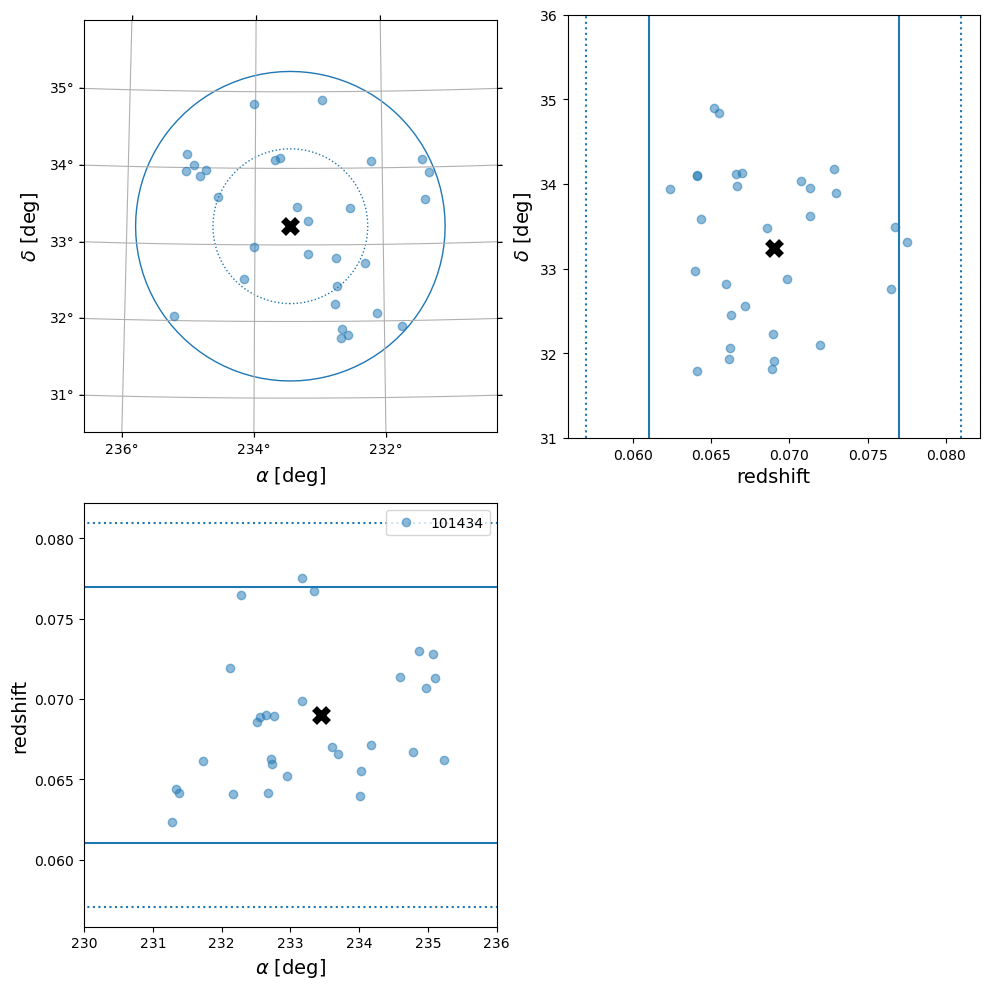

In [30]:
cluster = 101434

table3_i = table3_dict[cluster]
i = np.array(full_cluster) == cluster

cluster_center = cluster_coords[table3_i].transform_to('icrs')
print(cluster_center)

cluster_v = np.array(v_cluster)[i][0]

cluster_sigma = table3['sigP'][table3_i]
print(cluster_v, '+/-', cluster_sigma, 'km/s')

cluster_R2t_1p5 = np.arctan(1.5*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_3 = np.arctan(3*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_4 = np.arctan(4*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
print(cluster_R2t_3.to('degree'))



plt.figure(figsize=(10,10), tight_layout=True)

ax_sky = plt.subplot(221, projection='astro degrees zoom', center=cluster_center, radius=cluster_R2t_4)
ax_sky.grid()
    
ax_sky.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
            TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
            'o', 
            transform=ax_sky.get_transform('world'), 
            alpha=0.5, label=str(cluster))
ax_sky.plot(cluster_center.ra.deg, 
            cluster_center.dec.deg, 
            'kx', 
            transform=ax_sky.get_transform('world'), 
            ms=10, mew=5)

# 1.5 R2t
inner_limit = SphericalCircle(cluster_center, cluster_R2t_1p5, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
ax_sky.add_patch(inner_limit)

# 3 R2t
outer_limit = SphericalCircle(cluster_center, cluster_R2t_3, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
ax_sky.add_patch(outer_limit)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(222)
    
plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         'o', alpha=0.5, label=str(cluster))
    
plt.plot(cluster_v/c, 
         cluster_coords[table3_i].transform_to('icrs').dec.deg, 
         'kx', ms=10, mew=5)

# velocity limits
plt.vlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
            cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           -30, 90, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

#plt.xlim(xmin=0)
plt.ylim((31, 36))

plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(223)

plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         'o', alpha=0.5, label=str(cluster))

plt.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
         cluster_v/c, 
         'kx', ms=10, mew=5)

# velocity limits
plt.hlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
                     cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           0, 360, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

plt.xlim((230, 236))
# plt.ylim(ymin=0)

plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel('redshift', fontsize=14)

plt.legend();

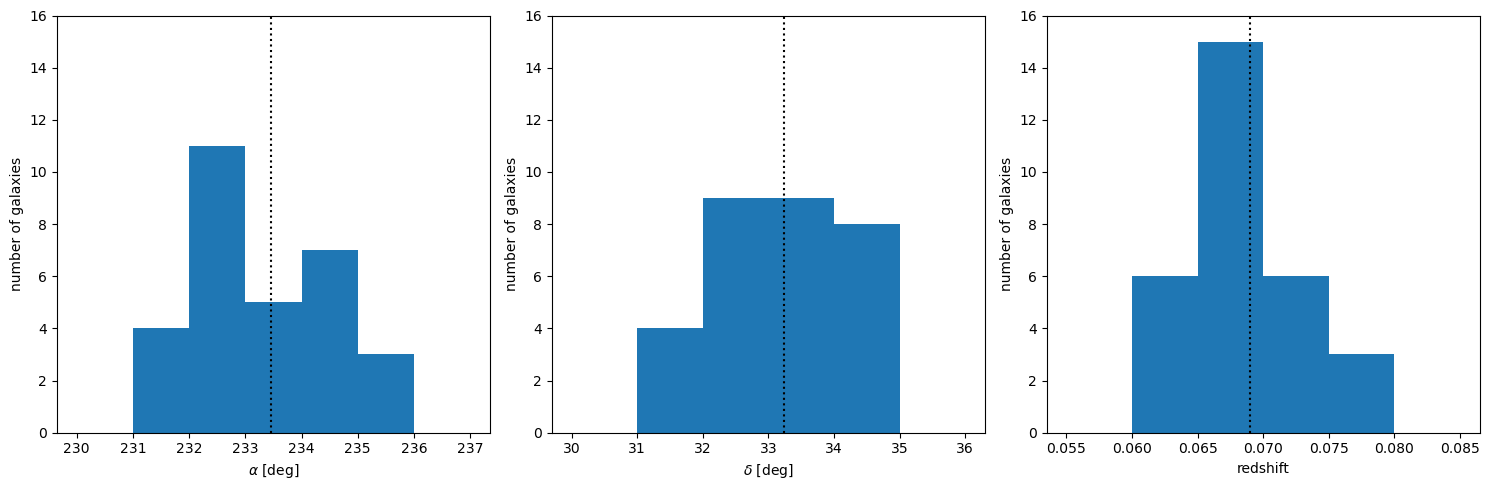

In [31]:
plt.figure(figsize=(15,5), tight_layout=True)

ymax = 16

plt.subplot(131)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         bins=np.arange(230, 238, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').ra.deg, 0, 50, colors='k', linestyles='dotted')
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(132)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         bins=np.arange(30, 37, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').dec.deg, 0, 100, colors='k', linestyles='dotted')
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(133)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         bins=np.arange(0.055, 0.09, 0.005))
plt.vlines(cluster_v/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax);

<SkyCoord (ICRS): (ra, dec) in deg
    (227.0389939, -0.84791796)>
22803.420720004207 +/- 1973 km/s
3.0258667706715956 deg


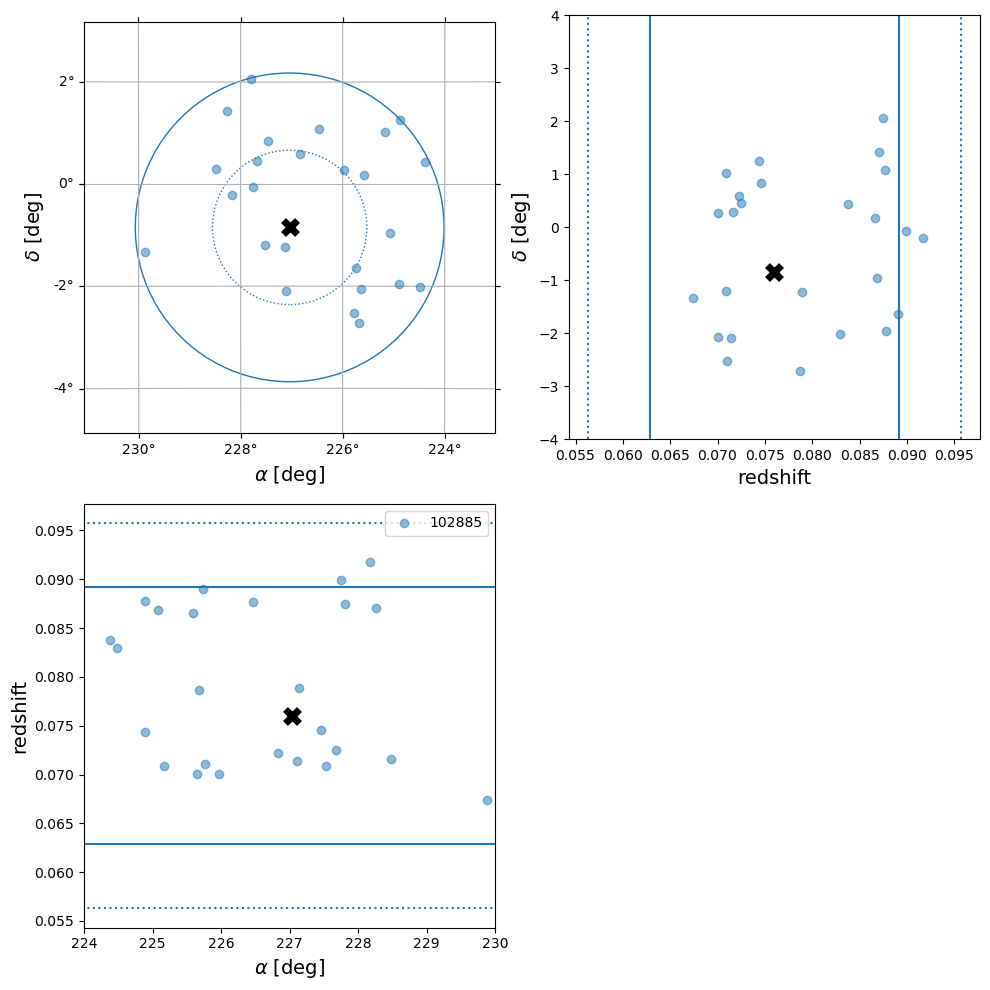

In [32]:
cluster = 102885

table3_i = table3_dict[cluster]
i = np.array(full_cluster) == cluster

cluster_center = cluster_coords[table3_i].transform_to('icrs')
print(cluster_center)

cluster_v = np.array(v_cluster)[i][0]

cluster_sigma = table3['sigP'][table3_i]
print(cluster_v, '+/-', cluster_sigma, 'km/s')

cluster_R2t_1p5 = np.arctan(1.5*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_3 = np.arctan(3*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_4 = np.arctan(4*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
print(cluster_R2t_3.to('degree'))



plt.figure(figsize=(10,10), tight_layout=True)

ax_sky = plt.subplot(221, projection='astro degrees zoom', center=cluster_center, radius=cluster_R2t_4)
ax_sky.grid()
    
ax_sky.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
            TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
            'o', 
            transform=ax_sky.get_transform('world'), 
            alpha=0.5, label=str(cluster))
ax_sky.plot(cluster_center.ra.deg, 
            cluster_center.dec.deg, 
            'kx', 
            transform=ax_sky.get_transform('world'), 
            ms=10, mew=5)

# 1.5 R2t
inner_limit = SphericalCircle(cluster_center, cluster_R2t_1p5, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
ax_sky.add_patch(inner_limit)

# 3 R2t
outer_limit = SphericalCircle(cluster_center, cluster_R2t_3, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
ax_sky.add_patch(outer_limit)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(222)
    
plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         'o', alpha=0.5, label=str(cluster))
    
plt.plot(cluster_v/c, 
         cluster_coords[table3_i].transform_to('icrs').dec.deg, 
         'kx', ms=10, mew=5)

# velocity limits
plt.vlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
            cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           -30, 90, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

#plt.xlim(xmin=0)
plt.ylim((-4, 4))

plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(223)

plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         'o', alpha=0.5, label=str(cluster))

plt.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
         cluster_v/c, 
         'kx', ms=10, mew=5)

# velocity limits
plt.hlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
                     cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           0, 360, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

plt.xlim((224, 230))
# plt.ylim(ymin=0)

plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel('redshift', fontsize=14)

plt.legend();

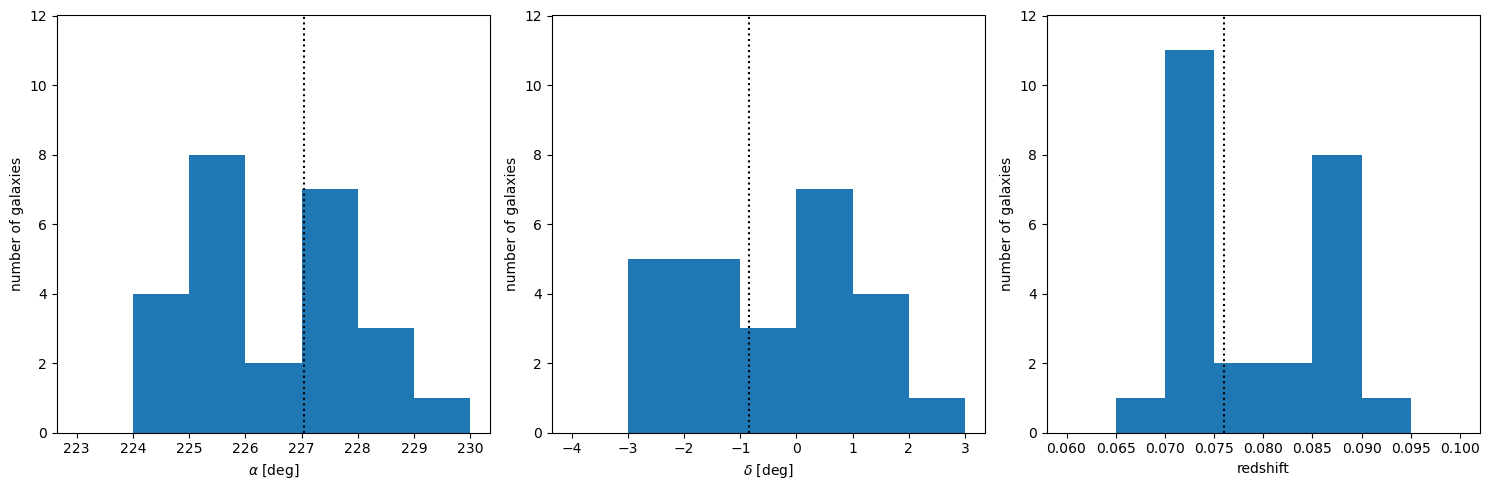

In [33]:
plt.figure(figsize=(15,5), tight_layout=True)

ymax = 12

plt.subplot(131)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         bins=np.arange(223, 231, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').ra.deg, 0, 50, colors='k', linestyles='dotted')
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(132)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         bins=np.arange(-4, 4, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').dec.deg, 0, 100, colors='k', linestyles='dotted')
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(133)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         bins=np.arange(0.06, 0.105, 0.005))
plt.vlines(cluster_v/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax);

<SkyCoord (ICRS): (ra, dec) in deg
    (201.84149945, -1.00863004)>
23768.402866248827 +/- 1465 km/s
2.156937087687581 deg


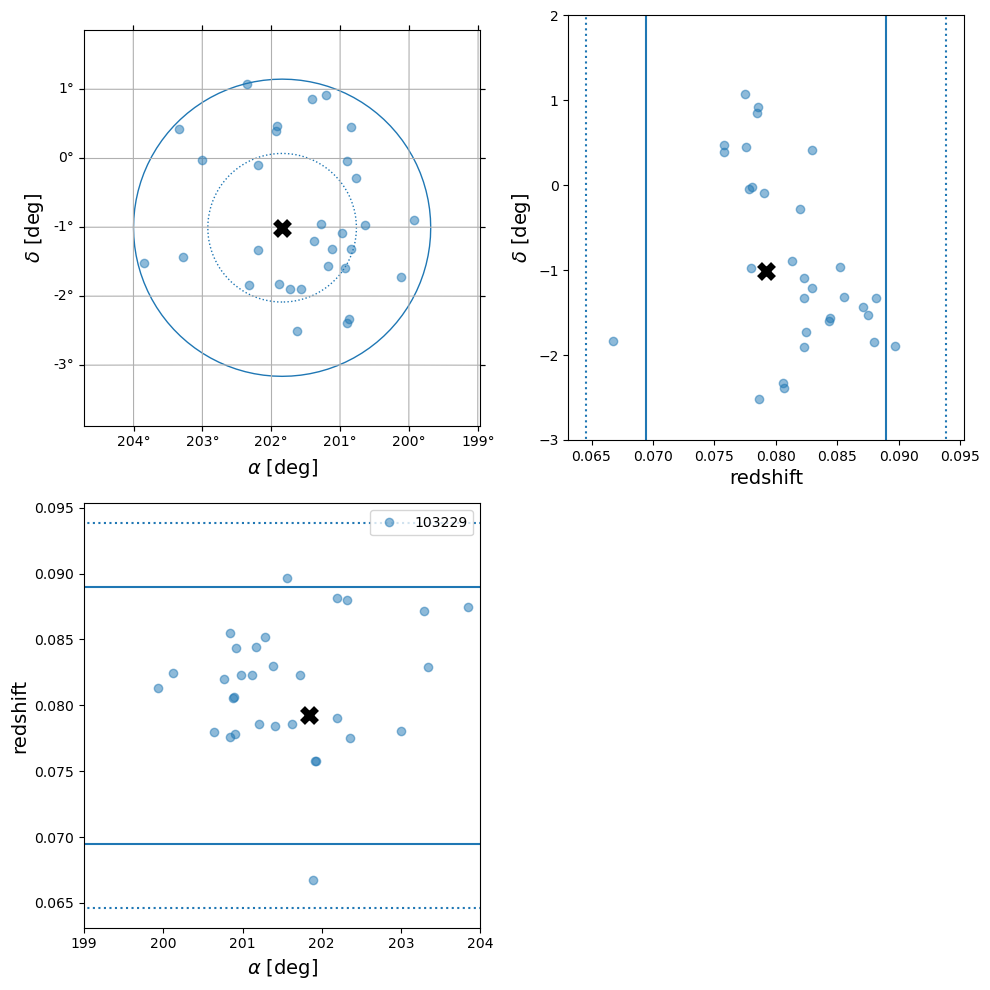

In [34]:
cluster = 103229

table3_i = table3_dict[cluster]
i = np.array(full_cluster) == cluster

cluster_center = cluster_coords[table3_i].transform_to('icrs')
print(cluster_center)

cluster_v = np.array(v_cluster)[i][0]

cluster_sigma = table3['sigP'][table3_i]
print(cluster_v, '+/-', cluster_sigma, 'km/s')

cluster_R2t_1p5 = np.arctan(1.5*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_3 = np.arctan(3*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_4 = np.arctan(4*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
print(cluster_R2t_3.to('degree'))



plt.figure(figsize=(10,10), tight_layout=True)

ax_sky = plt.subplot(221, projection='astro degrees zoom', center=cluster_center, radius=cluster_R2t_4)
ax_sky.grid()
    
ax_sky.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
            TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
            'o', 
            transform=ax_sky.get_transform('world'), 
            alpha=0.5, label=str(cluster))
ax_sky.plot(cluster_center.ra.deg, 
            cluster_center.dec.deg, 
            'kx', 
            transform=ax_sky.get_transform('world'), 
            ms=10, mew=5)

# 1.5 R2t
inner_limit = SphericalCircle(cluster_center, cluster_R2t_1p5, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
ax_sky.add_patch(inner_limit)

# 3 R2t
outer_limit = SphericalCircle(cluster_center, cluster_R2t_3, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
ax_sky.add_patch(outer_limit)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(222)
    
plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         'o', alpha=0.5, label=str(cluster))
    
plt.plot(cluster_v/c, 
         cluster_coords[table3_i].transform_to('icrs').dec.deg, 
         'kx', ms=10, mew=5)

# velocity limits
plt.vlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
            cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           -30, 90, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

#plt.xlim(xmin=0)
plt.ylim((-3, 2))

plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(223)

plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         'o', alpha=0.5, label=str(cluster))

plt.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
         cluster_v/c, 
         'kx', ms=10, mew=5)

# velocity limits
plt.hlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
                     cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           0, 360, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

plt.xlim((199, 204))
# plt.ylim(ymin=0)

plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel('redshift', fontsize=14)

plt.legend();

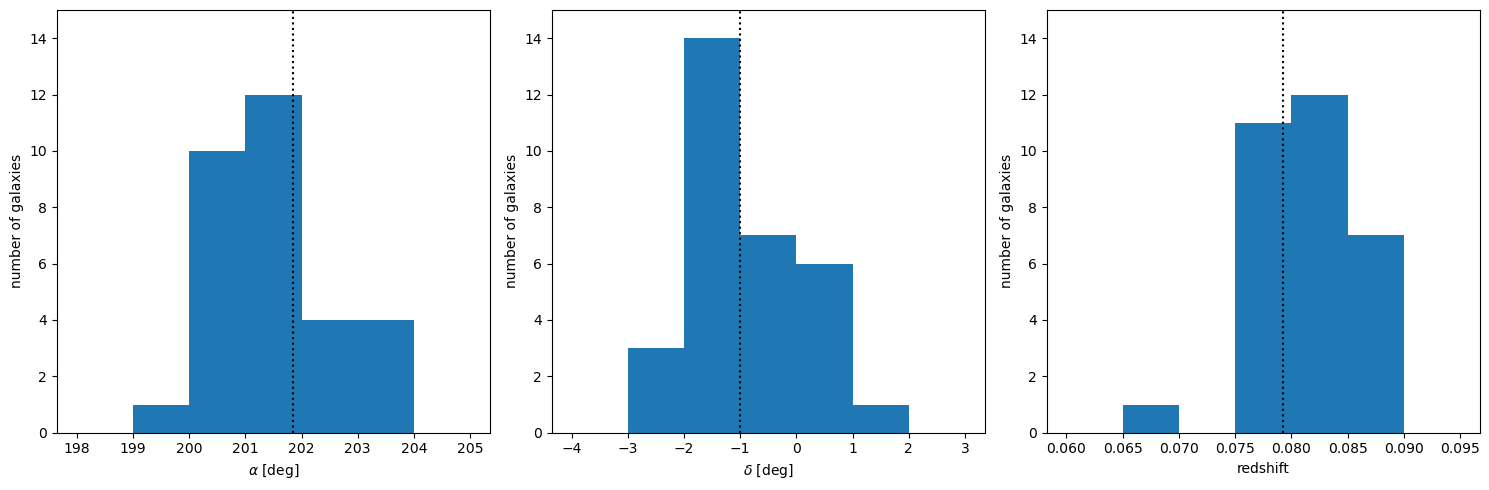

In [35]:
plt.figure(figsize=(15,5), tight_layout=True)

ymax = 15

plt.subplot(131)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         bins=np.arange(198, 206, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').ra.deg, 0, 50, colors='k', linestyles='dotted')
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(132)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         bins=np.arange(-4, 4, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').dec.deg, 0, 100, colors='k', linestyles='dotted')
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(133)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         bins=np.arange(0.06, 0.095, 0.005))
plt.vlines(cluster_v/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax);

<SkyCoord (ICRS): (ra, dec) in deg
    (68.12538017, -4.94510716)>
4508.16704541461 +/- 417 km/s
3.2374292077326365 deg


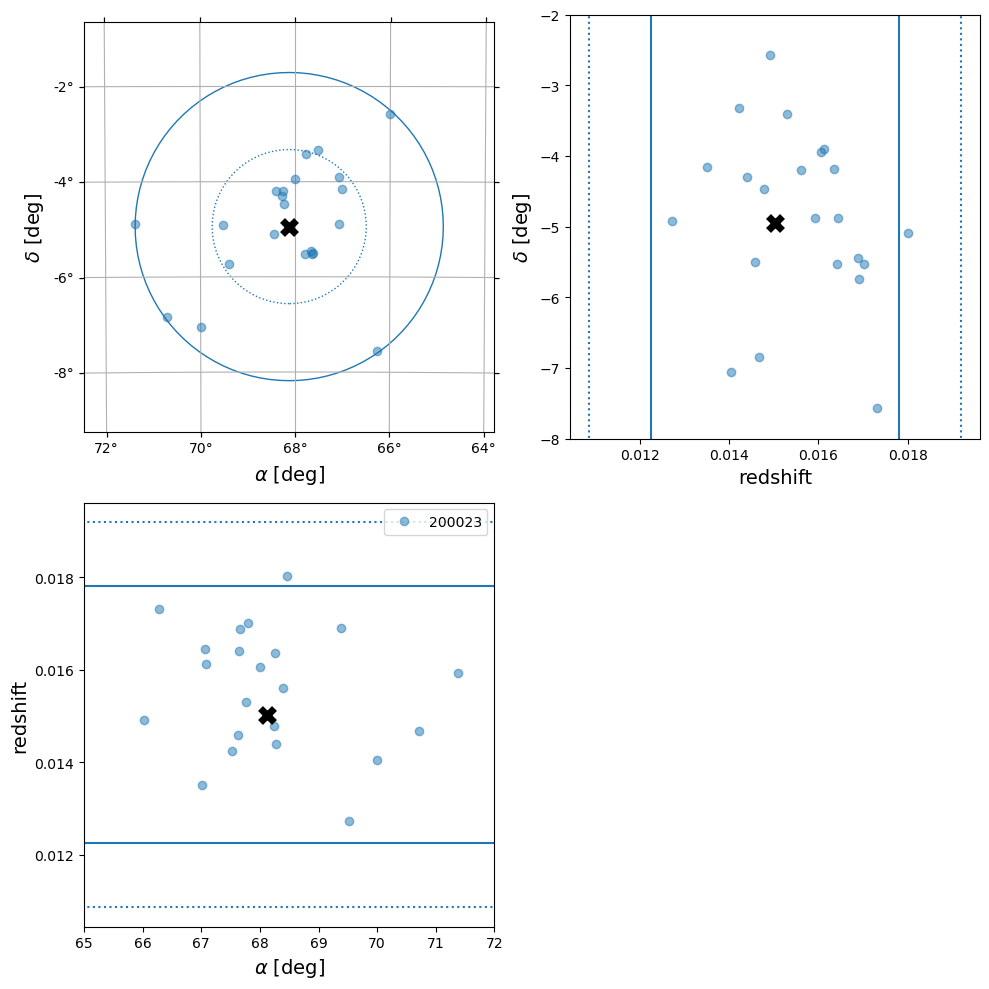

In [36]:
cluster = 200023

table3_i = table3_dict[cluster]
i = np.array(full_cluster) == cluster

cluster_center = cluster_coords[table3_i].transform_to('icrs')
print(cluster_center)

cluster_v = np.array(v_cluster)[i][0]

cluster_sigma = table3['sigP'][table3_i]
print(cluster_v, '+/-', cluster_sigma, 'km/s')

cluster_R2t_1p5 = np.arctan(1.5*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_3 = np.arctan(3*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
cluster_R2t_4 = np.arctan(4*table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
print(cluster_R2t_3.to('degree'))



plt.figure(figsize=(10,10), tight_layout=True)

ax_sky = plt.subplot(221, projection='astro degrees zoom', center=cluster_center, radius=cluster_R2t_4)
ax_sky.grid()
    
ax_sky.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
            TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
            'o', 
            transform=ax_sky.get_transform('world'), 
            alpha=0.5, label=str(cluster))
ax_sky.plot(cluster_center.ra.deg, 
            cluster_center.dec.deg, 
            'kx', 
            transform=ax_sky.get_transform('world'), 
            ms=10, mew=5)

# 1.5 R2t
inner_limit = SphericalCircle(cluster_center, cluster_R2t_1p5, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
ax_sky.add_patch(inner_limit)

# 3 R2t
outer_limit = SphericalCircle(cluster_center, cluster_R2t_3, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
ax_sky.add_patch(outer_limit)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(222)
    
plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         'o', alpha=0.5, label=str(cluster))
    
plt.plot(cluster_v/c, 
         cluster_coords[table3_i].transform_to('icrs').dec.deg, 
         'kx', ms=10, mew=5)

# velocity limits
plt.vlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
            cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           -30, 90, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

#plt.xlim(xmin=0)
plt.ylim((-8, -2))

plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(223)

plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         'o', alpha=0.5, label=str(cluster))

plt.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
         cluster_v/c, 
         'kx', ms=10, mew=5)

# velocity limits
plt.hlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
                     cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           0, 360, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

plt.xlim((65, 72))
# plt.ylim(ymin=0)

plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel('redshift', fontsize=14)

plt.legend();

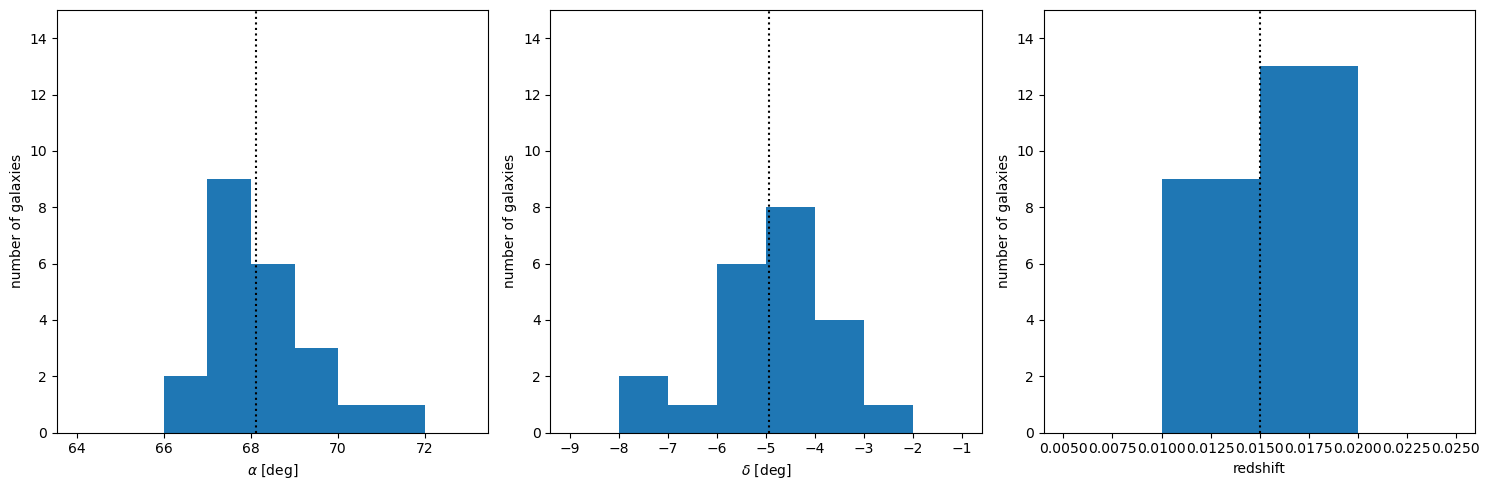

In [37]:
plt.figure(figsize=(15,5), tight_layout=True)

ymax = 15

plt.subplot(131)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         bins=np.arange(64, 74, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').ra.deg, 0, 50, colors='k', linestyles='dotted')
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(132)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         bins=np.arange(-9, 0, 1))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').dec.deg, 0, 100, colors='k', linestyles='dotted')
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax)

plt.subplot(133)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         bins=np.arange(0.005, 0.03, 0.005))
plt.vlines(cluster_v/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=ymax);

In [38]:
cluster_inspect = [101400, 101434, 102885, 103229, 200023]

for i in cluster_inspect:
    cluster = i
    print('cluster index:', i)
    
    table3_i = table3_dict[cluster]
    i = np.array(full_cluster) == cluster

    cluster_v = np.array(v_cluster)[i][0]

    cluster_sigma = table3['sigP'][table3_i]
    print('The velocity of the center of cluster is', cluster_v, '+/-', cluster_sigma, 'km/s')

    ## create temporary data storage space to assign and sort z-values for galaxies
    temp_array = []

    ## assign z-values to the data storage space and convert to numpy array
    temp_array = np.array(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'])
    temp_array = temp_array.tolist()

    ## sort the z-values and find the median
    temp_array.sort()

    num_galaxy = len(temp_array)
    if (num_galaxy%2 == 0):
        z_median = (temp_array[num_galaxy//2] + temp_array[num_galaxy//2 - 1])/2
    else:
        z_median = temp_array[num_galaxy//2]
    
    delta_v = cluster_v - c*z_median
    dv_over_sigP = delta_v / cluster_sigma
    
    print(dv_over_sigP)

cluster index: 101400
The velocity of the center of cluster is 22387.211385683422 +/- 1711 km/s
0.43318022354015734
cluster index: 101434
The velocity of the center of cluster is 20701.413487910413 +/- 1196 km/s
0.483386379935265
cluster index: 102885
The velocity of the center of cluster is 22803.420720004207 +/- 1973 km/s
-0.40994364256500415
cluster index: 103229
The velocity of the center of cluster is 23768.402866248827 +/- 1465 km/s
-0.5680481280932225
cluster index: 200023
The velocity of the center of cluster is 4508.16704541461 +/- 417 km/s
-0.5288426183412108
